In [77]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as alea
%matplotlib inline
from decimal import Decimal

In [78]:
from PlotFunctions import plot_signal, plot_position, plot_velocity, plot_variance

In [103]:
tau = 0.013
dt = 0.001 # step time
n = 2 # number of coordinates
k = 0.00001 # kind of accuracy parameter: the smaller k is, the more accurate is the pointing
n_try = 5
delay = .175

In [104]:
def fact(n): 
    """The factorial function
    Returns n!, that is n x (n-1) x (n-2) x ... x 1
    Recursive implementation
    """
    if n == 0:
        return 1
    else:
        return(n*fact(n-1))

In [105]:
# definition of A and B

A = np.zeros((n,n))
B = np.zeros(n)
for i in np.arange(n):
    for j in np.arange(i,n):
        A[i,j] = dt**(j-i)/fact(j-i)
A[n-1, n-1] = 1-dt/tau
B[n-1] = dt

In [106]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
        
    """
    if n == 0:
        return(np.eye(int(np.sqrt(np.size(A)))))
    elif n == 1:
        return A
    else:
        if n % 2 == 0:
            A_half = power(A, n//2)
            return(A_half.dot(A_half))
        else:
            A_half = power(A, (n-1)//2)
            return(A.dot(A_half.dot(A_half)))

def A_pow(A):
    A_pow_array = np.zeros((101,n,n))

    for i in np.arange(101):
        A_pow_array[i] = power(A,i)
    return A_pow_array

A_pow_array = A_pow(A)

def pow_fast(n):
    return A_pow_array[n]

ci0_array = np.zeros(101)

for i in np.arange(101):
    ci0_array[i] = (pow_fast(i).dot(B))[0]

ci1_array = np.zeros(101)

for i in np.arange(101):
    ci1_array[i] = (pow_fast(i).dot(B))[1]
    
#ci2_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci2_array[i] = (pow_fast(i).dot(B))[2]
    
#ci3_array = np.zeros(T+R+1)

#for i in np.arange(T+R+1):
#    ci3_array[i] = (pow_fast(i).dot(B))[3]

ci = np.array([ci0_array, ci1_array])#, ci2_array])

In [107]:
time = np.linspace(-0.025, 0.275, 301)
time_ms = time*1000

In [108]:
counter_right = np.zeros(n_try)
counter_left = np.zeros(n_try)
window = 15
proba = 0.7
distribution = (2*(alea.binomial(1, proba, n_try)-0.5)).astype(int) # binomial(1,p,n_try) : random selection of 1  with probability p and 0 with probability 1-p

In [109]:
n_iter = 5000
eta = 5000

In [110]:
u_rec = np.zeros((n_try,301))
pos_rec = np.zeros((n_try,301))
vel_rec = np.zeros((n_try,301))

In [111]:
v = 10
xT = 0

In [112]:
import time
debut = time.time()

for i in np.arange(n_try):
    if i < window:
        v_anticipation =v*((counter_right-counter_left)/window).sum()
    else:
        v_anticipation = v*((counter_right[(i-window):i]-counter_left[(i-window):i])/window).sum()
    u_rec[i, 0:200] = np.concatenate((np.zeros(25),1/tau*v_anticipation*np.ones(175)))
    pos_rec[i, 0:200] = np.concatenate((np.zeros(25),np.linspace(0, v_anticipation*delay,175)))
    vel_rec[i, 0:200] = np.concatenate((np.zeros(25),v_anticipation*np.ones(175)))

    if distribution[i] < 0:
        counter_left[i] = 1
    else:
        counter_right[i] = 1
    
    x0 = np.array([pos_rec[i,199], v_anticipation])
    target = np.array([v*distribution[i]*delay + xT, v*distribution[i]])
    
    t_Tv = 0.02468+0.001739*np.abs(target[0]-x0[0]) # see Transitioning from Saccade to SPEM uning LQTC, Korentis & Enderle
    t_T =  float(round(Decimal(t_Tv),3)) #.05 # saccade duration
    t_R =  .1-float(round(Decimal(t_Tv),3)) # .05 # fixing / pursuit duration
    T = int(np.round(t_T/dt))
    R = int(np.round(t_R/dt))
    
    def xT_f(t):
        return np.array([target[0]+target[1]*t*dt, target[1]])
    
    def expectation(u, t):
        """Computation of the expectation of the state vector at time t, given u
        """
        if t == 0:
            return x0
        else:
            return pow_fast(t).dot(x0)+(ci[:,0:t]*np.flipud(u[0:t])).sum(axis = 1)

    mult_v = np.array([1, 1])
    
    def variance(u, t):
        """Computation of the variance of the state vector at time t, given u
        """
        return k*(np.flipud(ci0_array[0:t]**2)*u[0:t]**2).sum()
    
    def cost_deriv(u, ii):
        """Derivative of the cost function with respect to u_i
        """
        if ii < T:
            return (2*np.transpose(ci[:,(T-ii-1):(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (T+np.arange(R+1))])).sum() + 2*k*u[ii]*(ci0_array[(T+1-ii-1):(T+R-ii)]**2).sum()
        else:
            return (2*np.transpose(ci[:,0:(T+R-ii)])*np.array([((expectation(u,t)-xT_f(t))*mult_v).tolist() for t in (ii+1+np.arange(R+T-ii))])).sum() + 2*k*u[ii]*(ci0_array[0:(T+R-ii)]**2).sum()

    ubang = np.zeros(T+R+1)
    
    u = ubang.copy()
    for i_iter in np.arange(n_iter):
        u_old = u.copy()
        u[0:T+R] = u_old[0:T+R] - eta*np.array([cost_deriv(u_old, i) for i in np.arange(T+R)])
        
    u_rec[i, 200:301] = u
    
    position = np.zeros(T+R+1)
    velocity = np.zeros(T+R+1)
    
    for j in np.arange(T+R+1):
        mean = expectation(u, j)
        position[j] = mean[0]
        velocity[j] = mean[1]
        
    pos_rec[i, 200:301] = position
    vel_rec[i, 200:301] = velocity
    
fin = time.time()


In [102]:
(fin-debut)/60

17.193585701783498

In [233]:
cible = -np.linspace(10,10+v*100*dt,101)
pos_rec[3,200:301]-cible

array([ 13.5       ,  13.53      ,  13.51532684,  13.45957822,
        13.36608857,  13.23795036,  13.07803398,  12.88900608,
        12.67334672,  12.43336526,  12.17121511,  11.88890761,
        11.58832486,  11.27123183,  10.93928764,  10.59405622,
        10.23701633,   9.86957101,   9.49305663,   9.1087514 ,
         8.71788361,   8.32163946,   7.92117071,   7.51760202,
         7.11203818,   6.70557121,   6.29928731,   5.89427389,
         5.49162647,   5.09245575,   4.69789473,   4.30910594,
         3.92728892,   3.5536879 ,   3.18959977,   2.83638242,
         2.49546339,   2.1683491 ,   1.85663443,   1.56201298,
         1.28628793,   1.03138359,   0.79935773,   0.59241478,
         0.41291997,   0.26341445,   0.14663164,   0.06551471,
         0.02323546,   0.02321465,   0.02322034,   0.02321699,
         0.02321641,   0.02321521,   0.02321411,   0.02321305,
         0.023212  ,   0.02321098,   0.02320998,   0.02320901,
         0.02320806,   0.02320713,   0.02320622,   0.02

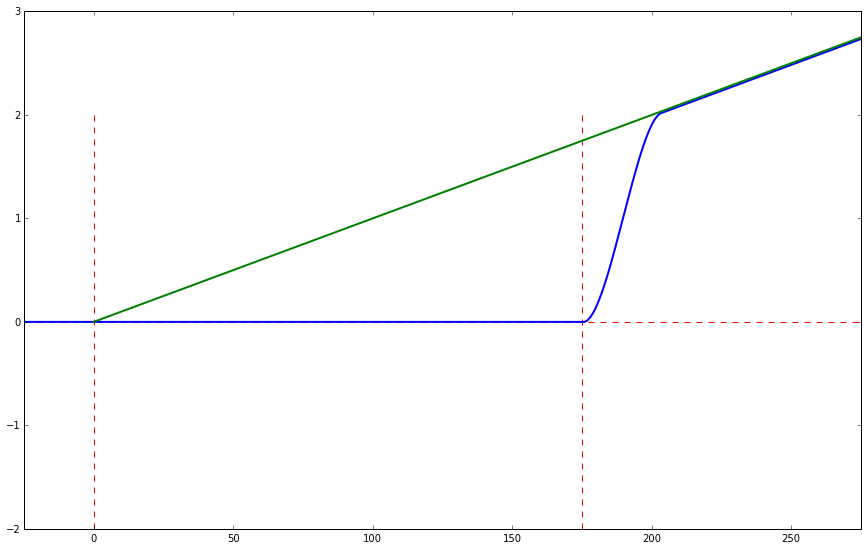

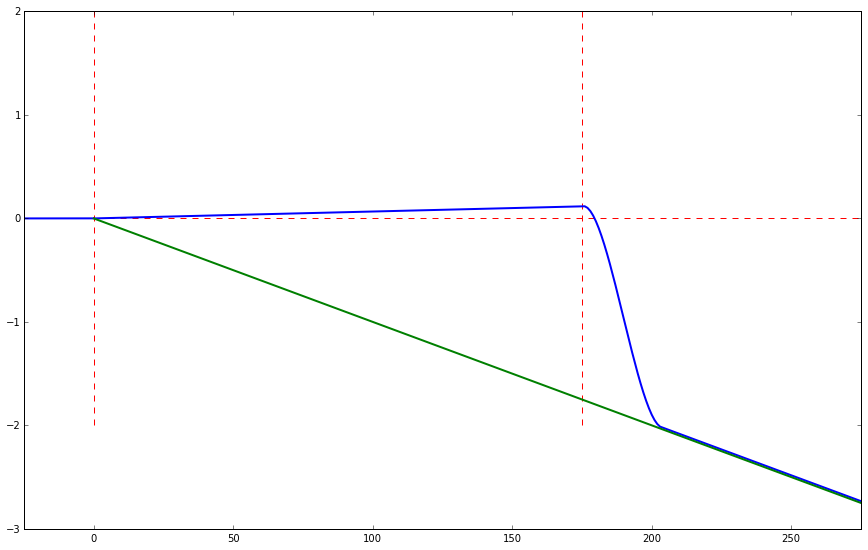

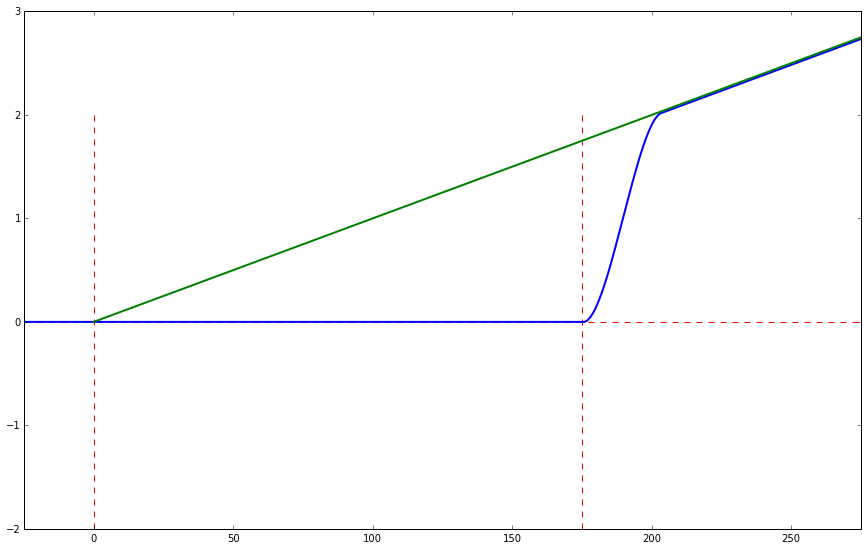

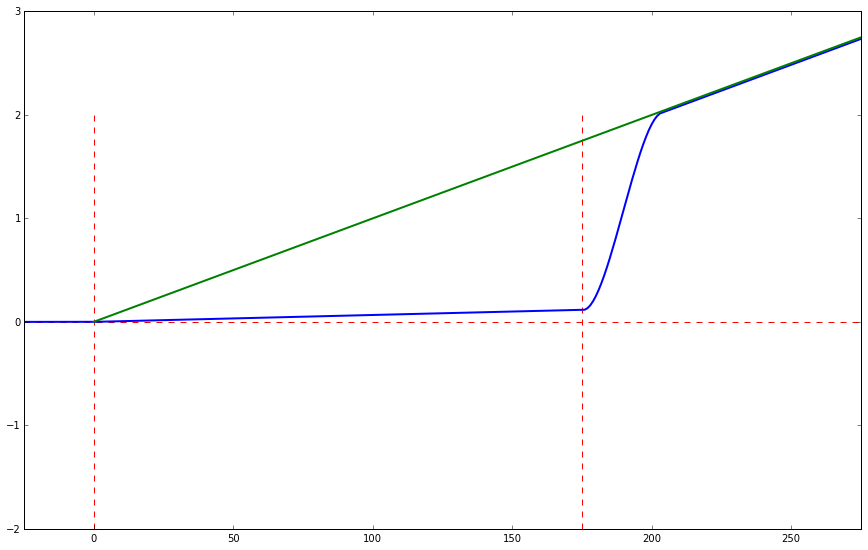

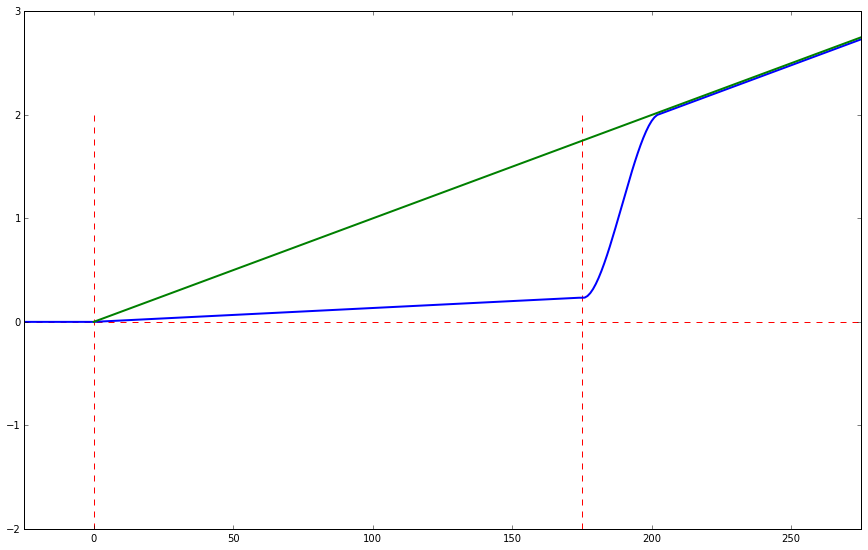

In [113]:
for i in np.arange(n_try):
    fig_width = 15
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
    plt.plot([-25, 275], [0, 0],'r--')
    plt.plot([0, 0], [-2, 2],'r--')
    plt.plot([175, 175],[-2,2],'r--')
    plt.plot(time_ms, pos_rec[i, :], lw=2)
    if distribution[i] > 0:
        plt.plot([0, 275],[0,v*(delay+t_T+t_R)],color='g', lw=2)
    else:
        plt.plot([0,275],[0,-v*(delay+t_T+t_R)],color='g', lw=2)
    ax.set_xlim(-25, 275)

    plt.show()